In [1]:
import pandas as pd
import numpy as np
from rich import print
from icecream import ic
import os
from pathlib import Path
import functools
import time
from time import perf_counter
import pickle
import matplotlib.pyplot as plt
import mplcursors
%matplotlib ipympl

from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm
import math

from embed_sources import bert_sentence_embed, create_sentence_embedding, encode_text_to_embedding_batched, generate_batches
from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

from utils import clusters_2D

In [24]:
filepath = Path.cwd().joinpath("embeddings", "so_database_app.csv")
so_df = pd.read_csv(filepath)
so_df.head()

,input_text,output_text,category
0,"python's inspect.getfile returns ""<string>""<p>...",<p><code>&lt;string&gt;</code> means that the ...,python
1,Passing parameter to function while multithrea...,<p>Try this and note the difference:</p>\n<pre...,python
2,How do we test a specific method written in a ...,"<p>Duplicate of <a href=""https://stackoverflow...",python
3,how can i remove the black bg color of an imag...,<p>The alpha channel &quot;disappears&quot; be...,python
4,How to extract each sheet within an Excel file...,<p>You need to specify the <code>index</code> ...,python


In [5]:
# convert input sentences to list
so_questions = so_df.input_text.to_list()
print(ic(len(so_questions)))
# batches = generate_batches(sentences= so_questions)

ic| len(so_questions): 2000


2000

In [3]:
with open("hmd_so_embeddings2000.pkl", "rb") as file:
    question_embeddings = pickle.load(file)

In [4]:
print(f"{len(question_embeddings)} embeddings of size \
{len(question_embeddings[0])}")

2000 embeddings of size 768

# Application of Embeddings

## Clustering

In [5]:
# Perfomr clustering on StackOverflow questions that are related to both Python and HTML
n_clusters = 4
kmeans = KMeans(
    n_clusters = n_clusters,
    random_state = 0,
    n_init = 'auto').fit(question_embeddings)

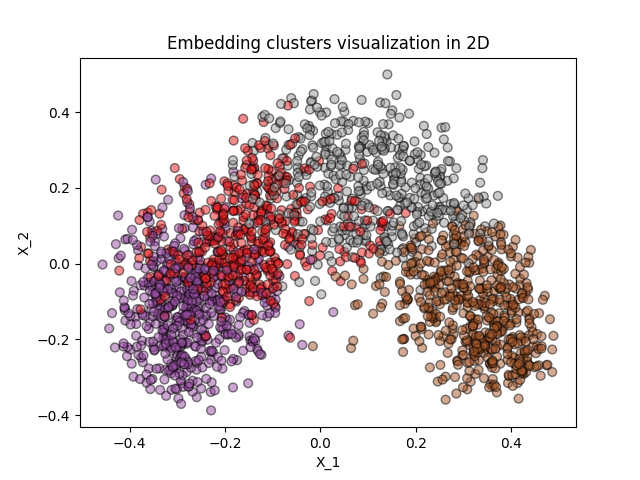

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/mplcursors/_pick_info.py:142: UserWarning: Selection.target.index is deprecated and will be removed in the future; use Selection.index instead.
  warnings.warn(


In [6]:
kmeans_labels = kmeans.labels_
PCA_model = PCA(n_components=2)
PCA_model.fit(question_embeddings)
low_dim_embedding = PCA_model.transform(question_embeddings)


clusters_2D(x_values = low_dim_embedding[:,0], y_values = low_dim_embedding[:,1], 
            labels = so_df, kmeans_labels = kmeans_labels)

## Anomaly or Outlier Detection

In [25]:
# input_text = """I am making cookies but don't remember the correct ingredient proportions. I have been unable to find anything on the web."""

input_text = "My favorite sport is soccer. That is why I support Chelsea FC."
model = SentenceTransformer("all-mpnet-base-v2")
outlier_embedding, _ = create_sentence_embedding([input_text], model, bert = False)

PCA of an array of one sample does not make sense.
So returning the full array.

In [27]:
# Add the embedding for the outlier to the original sentence embedding
embed_plus_outlier = np.vstack([question_embeddings, outlier_embedding])

(2001, 768)

In [29]:
# Add the embedding for the outlier to the original sentence embedding
embed_plus_outlier = np.vstack([question_embeddings, outlier_embedding])

# Add the new outlier text to the original dataframe
outlier_row = pd.Series([input_text, None, "sport"],
        index = so_df.columns)

so_df.loc[len(so_df)+1] = outlier_row

,input_text,output_text,category
2001,My favorite sport is soccer. That is why I sup...,None,sport


#### Use Isolation Forest to identify potential outliers

- `IsolationForest` classifier will predict `-1` for potential outliers, and `1` for non-outliers.
- You can inspect the rows that were predicted to be potential outliers and verify that the question about baking is predicted to be an outlier.

In [31]:
clf = IsolationForest(contamination=0.005,
            random_state = 2)
preds = clf.fit_predict(embed_plus_outlier)
print(f"{len(preds)} predictions. Set of possible values: {set(preds)}")

2001 predictions. Set of possible values: {1, -1}

In [34]:
# Print the outliers 
so_df.loc[preds == -1]

,input_text,output_text,category
159,How to set default python3 to python 3.9 inste...,<p>You should be able to use <code>python3.9 -...,python
198,Python Pandas: Best way to find local maximums...,<p>From <code>scipy</code> <code>argrelextrema...,python
201,Keras multivariate time series forecasting mod...,<p>Turns out my standarization of the data was...,python
745,What is a good way to automatically access a f...,<p>Simply change this line:</p>\n<pre><code>- ...,html
1070,Groupby multiindex columns using dictionary<p>...,<p>One way is to pass a function to <code>grou...,r
1099,How to compile/link ratfor code by gfortran co...,<p>You cannot compile Ratfor using gfortran. R...,r
1145,Dataflow SQL - Unsupported type Geography<p>I'...,<p>No unfortunately Dataflow SQL does not supp...,r
1347,Type of primary key index and what happens on ...,<p>I'll answer about MySQL's default storage e...,r
1385,How to delete specific users in bulk in WordPr...,<p>Use the WordPress CLI. There's a user delet...,r
2001,My favorite sport is soccer. That is why I sup...,None,sport
